An example of exploratory data analysis on data collected from [Etcheverry Roof](https://radwatch.berkeley.edu/dosenet/downloads).
Here is a link to download the [data](https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof.csv).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import sklearn
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
from bokeh.plotting import figure
output_notebook()
from scipy.stats import pearsonr
import scipy
from math import isnan
import seaborn as sns  # makes matplotlib beautiful

Loading BokehJS ...

In [2]:
etch_roof_pg_url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof.csv'  # pocket geiger data
data_pg = pd.read_csv(etch_roof_pg_url)
data_pg.head()

,deviceTime_utc,deviceTime_local,deviceTime_unix,cpm,cpmError
0,2018-06-25 18:50:40+00:00,2018-06-25 11:50:40-07:00,1529952640,2.8,0.748331
1,2018-06-25 18:45:40+00:00,2018-06-25 11:45:40-07:00,1529952340,2.4,0.692820
2,2018-06-25 18:40:40+00:00,2018-06-25 11:40:40-07:00,1529952040,2.4,0.692820
3,2018-06-25 18:35:40+00:00,2018-06-25 11:35:40-07:00,1529951740,1.8,0.600000
4,2018-06-25 18:30:40+00:00,2018-06-25 11:30:40-07:00,1529951440,3.4,0.824621


In [3]:
etch_roof_co2_url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof_adc.csv'  # CO2 data
data_co2 = pd.read_csv(etch_roof_co2_url)
data_co2.head()

,deviceTime_utc,deviceTime_local,deviceTime_unix,co2_ppm,noise
0,2018-06-25 18:50:39+00:00,2018-06-25 11:50:39-07:00,1529952639,565.98,3.17
1,2018-06-25 18:45:39+00:00,2018-06-25 11:45:39-07:00,1529952339,564.79,3.17
2,2018-06-25 18:40:39+00:00,2018-06-25 11:40:39-07:00,1529952039,573.11,3.14
3,2018-06-25 18:35:39+00:00,2018-06-25 11:35:39-07:00,1529951739,575.31,3.14
4,2018-06-25 18:30:39+00:00,2018-06-25 11:30:39-07:00,1529951439,574.84,3.18


In [4]:
# weather data
etch_roof_weather_url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof_weather.csv'
data_weather = pd.read_csv(etch_roof_weather_url)
data_weather.head()

,deviceTime_utc,deviceTime_local,deviceTime_unix,temperature,pressure,humidity
0,2018-06-25 18:50:39+00:00,2018-06-25 11:50:39-07:00,1529952639,19.67,1002.12,62.95
1,2018-06-25 18:45:39+00:00,2018-06-25 11:45:39-07:00,1529952339,19.69,1002.10,62.73
2,2018-06-25 18:40:39+00:00,2018-06-25 11:40:39-07:00,1529952039,19.68,1002.07,62.53
3,2018-06-25 18:35:39+00:00,2018-06-25 11:35:39-07:00,1529951739,19.69,1002.09,62.46
4,2018-06-25 18:30:39+00:00,2018-06-25 11:30:39-07:00,1529951439,19.71,1002.10,62.46


In [5]:
data_weather['datetime'] = pd.to_datetime(data_weather['deviceTime_utc'])

p = figure(plot_width=960, plot_height=480, title='Etcheverry Rooftop Temperature', x_axis_type='datetime')

p.line(data_weather['datetime'], data_weather['temperature'], line_width=2)
p.add_tools(HoverTool(tooltips=[('Time', '$x'), ('Temp', '$y')]))

p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Temperature'

show(p)

In [6]:
def near_time_search(list_, time, delta):
    """Binary search algorithm to find the datetime closest to 
    `time` within the list/array `list_`.
    
    :param list_:       SORTED list of timestamps
    :param time:        timestamp being searched for
    :return:            Nan if no timestamp found within `delta` of `time`
                        timestamp closest to `time`
    
    >>> near_time_search([1, 2, 3], 2, 1)
    2
    >>> near_time_search([3.4, 3.8, 4, 6], 4.1, 0.3)
    4
    >>> near_time_search([3.4, 3.8, 4, 6], 4.1, 0.05)
    nan
    >>> near_time_search([3.4, 3.8, 4, 6], 10, 3.5)
    nan
    >>> near_time_search([3.4, 3.8, 4, 6], 10, 7)  # should return `6`, not `4`
    6
    >>> near_time_search([3.4, 3.8, 4, 6], 5, 7)  # should return `6`, not `4`
    6
    >>> near_time_search(np.ones((1_000_000,)), 0.8, 0.2)
    1.0
    """
    lo = 0
    hi = len(list_)
    mid = (lo + hi) // 2
    
    while lo < mid < hi:
        if list_[mid] < time:
            lo = mid + 1
        elif list_[mid] > time:
            hi = mid - 1
        else:
            return list_[mid]
        mid = (lo + hi) // 2
    
    if (mid < hi) and (abs(list_[mid] - time) <= delta):
        return list_[mid]
    elif abs(list_[mid - 1] - time) <= delta:
        return list_[mid - 1]
    return float('nan')

def nts_with_arr(list_, time_arr, delta):
    result = []
    for elem in time_arr:
#         print(elem)
        result.append(near_time_search(list_, elem, delta))
    return result

# run doctests to see whether the function behaves as it should
import doctest
doctest.testmod()

TestResults(failed=0, attempted=7)

### Correlations Between $temperature$ and $CO_2$ Concentration

First, we need to find corresponding $temperature$ and $CO_2$ observations based on the timestamps of the obsevations. We will use the `near_time_search` function for this.

In [7]:
# the data needs to be sorted in ascending order according to time (it is
# sorted in descending order)
data_co2.sort_values('deviceTime_unix', inplace=True)
data_weather.sort_values('deviceTime_unix', inplace=True)

co2_temp_df = pd.DataFrame(columns=['co2_time', 'temp_time', 'co2', 'temp'])
co2_temp_df['co2_time'] = data_co2['deviceTime_unix']
co2_temp_df['temp_time'] = nts_with_arr(data_weather['deviceTime_unix'].tolist(),
                                        co2_temp_df['co2_time'].tolist(),
                                        delta=300)

time_diff = (co2_temp_df['temp_time'] - co2_temp_df['co2_time'])
print(time_diff)

57584      0.0
57583   -300.0
57582      0.0
57581   -300.0
57580      0.0
57579   -300.0
57578      0.0
57577      0.0
57576   -300.0
57575      0.0
57574   -300.0
57573      0.0
57572   -300.0
57571      0.0
57570      0.0
57569   -300.0
57568      0.0
57567   -300.0
57566      0.0
57565   -300.0
57564      0.0
57563      0.0
57562   -300.0
57561      0.0
57560   -300.0
57559      0.0
57558   -300.0
57557      0.0
57556      0.0
57555   -300.0
         ...  
29         0.0
28      -300.0
27         0.0
26         0.0
25      -300.0
24         0.0
23      -300.0
22         0.0
21      -300.0
20         0.0
19         0.0
18      -300.0
17         0.0
16      -300.0
15         NaN
14      -299.0
13         0.0
12         0.0
11      -300.0
10         0.0
9       -300.0
8          0.0
7       -300.0
6          0.0
5       -300.0
4          0.0
3       -300.0
2          0.0
1       -300.0
0          0.0
Length: 57585, dtype: float64


Interestingly, there are many instances where the $temperature$ and $CO_2$ timestamps are different by about 300 seconds. These probably correspond to instances where one of the sensors did not make a measurement, so we would want these to be `NaN` and thus excluded from our calculation of correlation.

In [8]:
# let's see how many differences are +-300 or NaN
time_diff.value_counts(dropna=False)

 0.0      28231
-300.0    20876
NaN        3801
-299.0     1873
 1.0        597
-298.0      543
-294.0      338
-5.0        232
 2.0        177
-6.0        152
-293.0      126
 6.0         92
-1.0         91
 295.0       63
 294.0       40
-2.0         36
-297.0       31
 298.0       20
-296.0       17
 4.0         16
-3.0         15
 7.0         14
-295.0       13
 299.0       13
-182.0       12
 3.0          9
-292.0        9
-290.0        7
 300.0        7
 5.0          7
          ...  
-16.0         2
-289.0        2
 291.0        2
-281.0        2
-22.0         2
-261.0        2
-40.0         2
-12.0         2
-28.0         1
 12.0         1
 283.0        1
-278.0        1
-256.0        1
-26.0         1
-106.0        1
-285.0        1
 276.0        1
-275.0        1
-272.0        1
-44.0         1
-131.0        1
-110.0        1
-67.0         1
-98.0         1
-257.0        1
-202.0        1
-33.0         1
-91.0         1
 296.0        1
-252.0        1
Length: 82, dtype: int64

We don't want to consider elements with time difference more than a few seconds, because those will spuriously lead us to count the same observation twice (think why!). Pandas lets us easily remove rows with duplicate values using the `DataFrame.drop_duplicates` function.

In [9]:
co2_temp_df['temp_time'] = nts_with_arr(data_weather['deviceTime_unix'].tolist(),
                                        co2_temp_df['co2_time'].tolist(),
                                        delta=300)  # <-- delta=30 instead of 300
# print("==========================================================================")
# print("Let's see how many repeated timestamps we have with `delta` of 300 seconds.")
# print("--------------------------------------------------------------------------")
# print(co2_temp_df['temp_time'].value_counts(dropna=False))

# co2_temp_df['pg_time'] = nts_with_arr(data_pg['deviceTime_unix'].tolist(),
#                                       co2_temp_df['co2_time'].tolist(),
#                                       delta=1500)

# Now let's remove the duplicates
co2_temp_df = co2_temp_df.drop_duplicates(subset=['temp_time'], keep='first')
print(co2_temp_df)

         co2_time     temp_time  co2 temp
57584  1510944049  1.510944e+09  NaN  NaN
57582  1510944649  1.510945e+09  NaN  NaN
57580  1510945249  1.510945e+09  NaN  NaN
57578  1510945849  1.510946e+09  NaN  NaN
57577  1510946149  1.510946e+09  NaN  NaN
57575  1510946749  1.510947e+09  NaN  NaN
57573  1510947349  1.510947e+09  NaN  NaN
57571  1510947949  1.510948e+09  NaN  NaN
57570  1510948249  1.510948e+09  NaN  NaN
57568  1510948849  1.510949e+09  NaN  NaN
57566  1510949449  1.510949e+09  NaN  NaN
57564  1510950049  1.510950e+09  NaN  NaN
57563  1510950349  1.510950e+09  NaN  NaN
57561  1510950949  1.510951e+09  NaN  NaN
57559  1510951549  1.510952e+09  NaN  NaN
57557  1510952149  1.510952e+09  NaN  NaN
57556  1510952449  1.510952e+09  NaN  NaN
57554  1510953049  1.510953e+09  NaN  NaN
57552  1510953649  1.510954e+09  NaN  NaN
57550  1510954249  1.510954e+09  NaN  NaN
57549  1510954549  1.510955e+09  NaN  NaN
57547  1510955149  1.510955e+09  NaN  NaN
57545  1510955749  1.510956e+09  N

Now let's fill in the $temperature$ and $CO_2$ concentration values.

In [10]:
# first let's remove rows where `temp_time` is `NaN`
# make the entire row `NaN` if `temp_time` is `NaN`
for idx, _, temp_time, _, _ in co2_temp_df.itertuples():
    if isnan(temp_time):
        co2_temp_df.loc[idx, 'co2_time'] = float('nan')
# drop rows that are filled with `NaN`s only
co2_temp_df = co2_temp_df.dropna(how='all')

In [11]:
# now let's fill in the values
for idx, _, _, _, _ in co2_temp_df.itertuples():
    try:
        co2_temp_df.loc[idx, 'co2'] = data_co2.loc[idx, 'co2_ppm']
        co2_temp_df.loc[idx, 'temp'] = data_weather.loc[idx, 'temperature']
    except KeyError as ke:
#         print('Skipped index %d' % idx)
        continue
co2_temp_df

,co2_time,temp_time,co2,temp
57584,1.510944e+09,1.510944e+09,544.68,NaN
57582,1.510945e+09,1.510945e+09,572.51,NaN
57580,1.510945e+09,1.510945e+09,563.1,NaN
57578,1.510946e+09,1.510946e+09,566.09,NaN
57577,1.510946e+09,1.510946e+09,564.07,NaN
57575,1.510947e+09,1.510947e+09,561.7,NaN
57573,1.510947e+09,1.510947e+09,565.86,NaN
57571,1.510948e+09,1.510948e+09,564.58,NaN
57570,1.510948e+09,1.510948e+09,572.19,NaN
57568,1.510949e+09,1.510949e+09,564.95,NaN


Let's clean up `NaN`s one last time before we find the ~correlations~!!!

In [12]:
co2_temp_df = co2_temp_df.dropna()
co2_temp_df

,co2_time,temp_time,co2,temp
57371,1.511000e+09,1.511000e+09,471.72,17.57
57369,1.511000e+09,1.511000e+09,471.16,16.58
57368,1.511001e+09,1.511001e+09,472.03,16.39
57366,1.511001e+09,1.511001e+09,474.86,16.4
57364,1.511002e+09,1.511002e+09,474.91,16.74
57362,1.511003e+09,1.511003e+09,467.75,17.09
57361,1.511003e+09,1.511003e+09,465.32,17.24
57359,1.511003e+09,1.511003e+09,471.89,16.91
57357,1.511004e+09,1.511004e+09,467.57,17.19
57355,1.511005e+09,1.511005e+09,461.67,17.51


Now let's find the correlation between $temperature$ and $CO_2$ concentration (finally!!!) using the handy `scipy.stats.pearsonr` function, which also returns the two-tailed p-value for the two series of data being analyzed.

In [13]:
r_value, p_value = pearsonr(co2_temp_df['temp'], co2_temp_df['co2'])
print(f"Pearson's correlation coefficient: {r_value}")
print(f"Two-tailed p-value: {p_value}")

Pearson's correlation coefficient: 0.044320617523771116
Two-tailed p-value: 3.948398229481934e-15


A correlation coefficient $<0.30$ suggests there is no correlation between temperature and $CO_2$ concentration. Let's verify that graphically.

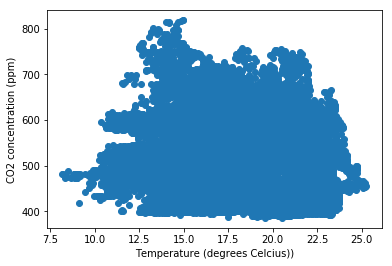

In [14]:
plt.scatter(co2_temp_df['temp'], co2_temp_df['co2'])
plt.xlabel("Temperature (degrees Celcius))")
plt.ylabel("CO2 concentration (ppm)")
plt.show()

Clearly, there is no correlation between temperature and $CO_2$ concentration.

## More Correlations
Let's look for correlated variables a little more systematically by making a correlation matrix. Pandas lets us do that easily using the `DataFrame.corr` function.

In [15]:
co2_temp_df = co2_temp_df.assign(humidity=pd.Series(np.full(co2_temp_df.shape[0], float('nan'))).values)
co2_temp_df = co2_temp_df.assign(pressure=pd.Series(np.full(co2_temp_df.shape[0], float('nan'))).values)

In [16]:
for idx, _, _, _, _, _, _ in co2_temp_df.itertuples():
    try:
        co2_temp_df.loc[idx, 'pressure'] = data_weather.loc[idx, 'humidity']
        co2_temp_df.loc[idx, 'humidity'] = data_weather.loc[idx, 'pressure']
    except KeyError as ke:
        print('Skipped index %d' % idx)
        continue

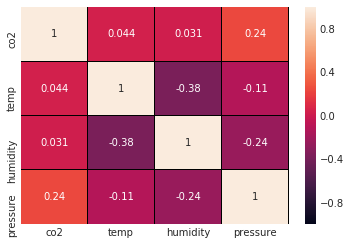

In [17]:
co2_temp_df.dropna()
co2_temp_df['temp'] = co2_temp_df['temp'].astype(float)
co2_temp_df['co2'] = co2_temp_df['co2'].astype(float)

correlation_matrix = co2_temp_df.corr()

with sns.axes_style("dark"):
    sns.heatmap(data=correlation_matrix.loc['co2': 'pressure', 'co2': 'pressure'],
                vmin=-1.0, vmax=1.0, annot=True, cbar=True, linecolor='#000000FF', linewidth='0.1')

Okay, so there is weak correlation ($0.7\geq|r|\geq0.3$) between $humidity$ and $pressure$, and very weak correlation ($r<0.3$) for the rest.

## Radiation
Now, finally, let's see if weather indicators have any correlation with the background radiation level.

In [18]:
co2_temp_df = co2_temp_df.assign(radiation=pd.Series(np.full(co2_temp_df.shape[0], float('nan'))).values)

# co2_temp_df['pg_time'] = nts_with_arr(co2_temp_df['co2_time'].astype(int).tolist(),
#                                       data_pg['deviceTime_unix'].tolist(),
#                                       delta=300)

pg_tt = pd.Series(nts_with_arr(co2_temp_df['co2_time'].astype(int).tolist(),
                     data_pg['deviceTime_unix'].tolist(),
                     delta=300))

# time_diff = (data_pg['deviceTime_unix'] - co2_temp_df['co2_time'])
pg_tt.dropna(inplace=True)
pg_tt.drop_duplicates(inplace=True)

co2_temp_df['pg_time'] = nts_with_arr(pg_tt.tolist(),
                                      co2_temp_df['co2_time'].astype(int).tolist(),
                                      delta=300)

print(pg_tt.value_counts(dropna=False))

1.513385e+09    1
1.511786e+09    1
1.520050e+09    1
1.511810e+09    1
1.511808e+09    1
1.511806e+09    1
1.511804e+09    1
1.511802e+09    1
1.511800e+09    1
1.520053e+09    1
1.527641e+09    1
1.511794e+09    1
1.520064e+09    1
1.511790e+09    1
1.519575e+09    1
1.511784e+09    1
1.511817e+09    1
1.511782e+09    1
1.511780e+09    1
1.520065e+09    1
1.511776e+09    1
1.511773e+09    1
1.511771e+09    1
1.511769e+09    1
1.511768e+09    1
1.511766e+09    1
1.511763e+09    1
1.511761e+09    1
1.511759e+09    1
1.511757e+09    1
               ..
1.523513e+09    1
1.523516e+09    1
1.523571e+09    1
1.523569e+09    1
1.528493e+09    1
1.523566e+09    1
1.523563e+09    1
1.523561e+09    1
1.523560e+09    1
1.523558e+09    1
1.523555e+09    1
1.523554e+09    1
1.523552e+09    1
1.523549e+09    1
1.523548e+09    1
1.523546e+09    1
1.523544e+09    1
1.523542e+09    1
1.523539e+09    1
1.523537e+09    1
1.523534e+09    1
1.523533e+09    1
1.523532e+09    1
1.523530e+09    1
1.523527e+

In [19]:
data_pg['deviceTime_unix']

0         1529952640
1         1529952340
2         1529952040
3         1529951740
4         1529951440
5         1529951140
6         1529950840
7         1529950540
8         1529950240
9         1529949940
10        1529949640
11        1529949340
12        1529949040
13        1529948740
14        1529948440
15        1529948146
16        1529947846
17        1529947540
18        1529947240
19        1529946940
20        1529946640
21        1529946340
22        1529946040
23        1529945740
24        1529945440
25        1529945140
26        1529944840
27        1529944540
28        1529944240
29        1529943940
             ...    
221037    1447995129
221038    1447994828
221039    1447994528
221040    1447994227
221041    1447993927
221042    1447993626
221043    1447993336
221044    1447993035
221045    1447992735
221046    1447992434
221047    1447992134
221048    1447991833
221049    1447991533
221050    1447991232
221051    1447990932
221052    1447990631
221053    144

In [20]:
co2_temp_df['pg_time'].value_counts(dropna=False)

NaN              31393
 1.520014e+09        1
 1.511000e+09        1
Name: pg_time, dtype: int64

In [21]:
# for idx, c02_time, _, _, _, _, _, _ in co2_temp_df.itertuples():
#     try:
#         co2_temp_df.loc[idx, 'radiation'] = data_pg.loc[near_time_search(list_=), 'humidity']
#     except KeyError as ke:
#         print('Skipped index %d' % idx)
#         continue